In [1]:
import os
import sys
import scipy.io
import scipy.misc
import imageio
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf

%matplotlib inline

/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)


In [2]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")
print(model)

{'input': <tf.Variable 'Variable:0' shape=(1, 300, 400, 3) dtype=float32_ref>, 'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>, 'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 300, 400, 64) dtype=float32>, 'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 150, 200, 64) dtype=float32>, 'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 150, 200, 128) dtype=float32>, 'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 150, 200, 128) dtype=float32>, 'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 75, 100, 128) dtype=float32>, 'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 75, 100, 256) dtype=float32>, 'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 38, 50, 256) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_8:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv4_2': <tf.Tensor 'Relu_9:0' shap

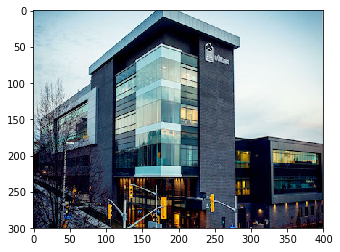

In [3]:
content_image = imageio.imread("/Users/chukaezema/Documents/style_transfer/images/uOttawa-building1.jpg")
imshow(content_image)

In [4]:
def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    
    # Retrieving the dimensions from a_G 
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshaping a_C and a_G 
    a_C_unrolled = tf.transpose(
    tf.reshape(a_C,(1, n_H, n_W, n_C)),
    name='transpose'
)
    a_G_unrolled = tf.transpose(
    tf.reshape(a_G,(1, n_H, n_W, n_C)),
    name='transpose'
)
    
    # computing the cost with tensorflow 
    J_content = (1/(4*n_H*n_W*n_C))*tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled)))
    
    return J_content

In [5]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_content = compute_content_cost(a_C, a_G)
    print("J_content = " + str(J_content.eval()))

J_content = 6.7655935


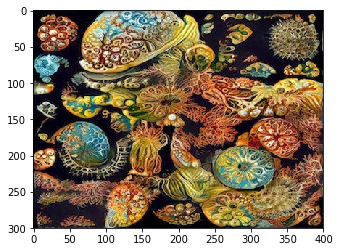

In [6]:
style_image = imageio.imread("/Users/chukaezema/Documents/style_transfer/images/web_IMG_3091.jpg")
imshow(style_image)

In [7]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    
    GA = tf.matmul(A, tf.transpose(A))

    
    return GA

In [8]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    A = tf.random_normal([3, 2*1], mean=1, stddev=4)
    GA = gram_matrix(A)
    
    print("GA = " + str(GA.eval()))

GA = [[ 6.422305 -4.429122 -2.096682]
 [-4.429122 19.465837 19.563871]
 [-2.096682 19.563871 20.686462]]


In [9]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # Retrieving dimensions from a_G 
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshaping the images to have shape (n_C, n_H*n_W)
    a_S = tf.transpose(tf.reshape(a_S, [n_H*n_W, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, [n_H*n_W, n_C]))

    # Computing gram_matrices for both images S and G 
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss (≈1 line)
    J_style_layer = (1/(4*np.square(n_C)*np.square(n_H*n_W))) * tf.reduce_sum(tf.square(tf.subtract(GS,GG)))
    
    
    return J_style_layer

In [10]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_S = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_style_layer = compute_layer_style_cost(a_S, a_G)
    
    print("J_style_layer = " + str(J_style_layer.eval()))

J_style_layer = 9.190278


In [11]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [12]:
def compute_style_cost(model, STYLE_LAYERS):

    # initializing the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Selecting the output tensor of the currently selected layer
        out = model[layer_name]

        # Setting a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Setting a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        a_G = out
        
        # Computing style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Adding coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

In [13]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):

    J = (alpha*J_content)+(beta*J_style)
    
    return J

In [14]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(3)
    J_content = np.random.randn()    
    J_style = np.random.randn()
    J = total_cost(J_content, J_style)
    print("J = " + str(J))

J = 35.34667875478276


In [15]:
# Resetting the graph
tf.reset_default_graph()

# Starting interactive session
sess = tf.InteractiveSession()

In [16]:
content_image = imageio.imread("/Users/chukaezema/Documents/style_transfer/images/uOttawa-building1.jpg")
content_image = reshape_and_normalize_image(content_image)

In [17]:
style_image = imageio.imread("/Users/chukaezema/Documents/style_transfer/images/web_IMG_3091.jpg")
style_image = reshape_and_normalize_image(style_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


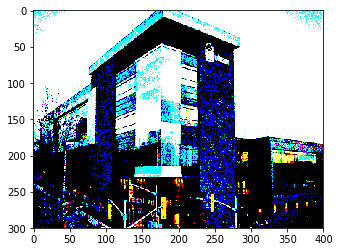

In [18]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

In [19]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")

In [20]:
# Assigning the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Selecting the output tensor of layer conv4_2
out = model['conv4_2']

# Setting a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Setting a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
a_G = out

# Computing the content cost
J_content = compute_content_cost(a_C, a_G)

In [21]:
# Assigning the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Computing the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

In [22]:
J = total_cost(J_content, J_style, alpha = 10, beta = 40)

In [23]:
# defining optimizer 
optimizer = tf.train.AdamOptimizer(2.0)

# defining train_step 
train_step = optimizer.minimize(J)

In [24]:
def model_nn(sess, input_image, num_iterations = 200):
    
    # Initializing global variables (you need to run the session on the initializer)
    sess.run(tf.global_variables_initializer())
    
    # Running the noisy input image (initial generated image) through the model. Use assign().
    sess.run(model['input'].assign(input_image))
    
    for i in range(num_iterations):
    
        # Running the session on the train_step to minimize the total cost
        _ = sess.run(train_step)
        ### END CODE HERE ###
        
        # Computing the generated image by running the session on the current model['input']
        generated_image = sess.run(model['input'])

        # Printing every 20 iteration.
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            save_image("output/" + str(i) + ".png", generated_image)
    
    # saving last generated image
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

In [25]:
model_nn(sess, generated_image)

Iteration 0 :
total cost = 16274594000.0
content cost = 12145.106
style cost = 406861800.0
Iteration 20 :
total cost = 3340619300.0
content cost = 24209.996
style cost = 83509420.0
Iteration 40 :
total cost = 1154286600.0
content cost = 27840.441
style cost = 28850204.0
Iteration 60 :
total cost = 596285000.0
content cost = 29177.174
style cost = 14899831.0
Iteration 80 :
total cost = 376913060.0
content cost = 30033.135
style cost = 9415318.0
Iteration 100 :
total cost = 262797980.0
content cost = 30612.822
style cost = 6562296.5
Iteration 120 :
total cost = 197805330.0
content cost = 31078.73
style cost = 4937363.5
Iteration 140 :
total cost = 158104160.0
content cost = 31446.676
style cost = 3944742.5
Iteration 160 :
total cost = 132029860.0
content cost = 31718.58
style cost = 3292816.8
Iteration 180 :
total cost = 113617430.0
content cost = 31952.043
style cost = 2832447.8


array([[[[-104.371185 ,  -41.434895 ,    2.6333387],
         [ -68.081924 ,  -64.50185  ,  -11.004629 ],
         [ -77.291046 ,  -35.914856 ,  -28.6733   ],
         ...,
         [  31.428366 ,   50.525455 ,   63.499886 ],
         [  29.460175 ,   57.66908  ,   65.83924  ],
         [ -50.696644 ,  -35.89296  ,    1.8653758]],

        [[ -83.26089  ,  -46.56915  ,  -18.998598 ],
         [ -48.115448 ,  -58.426098 ,   17.959846 ],
         [ -50.885414 ,  -37.15307  ,  -21.56702  ],
         ...,
         [  62.586296 ,   94.0249   ,  108.670456 ],
         [  62.03983  ,   72.696495 ,   74.41518  ],
         [  47.136547 ,   71.14403  ,   62.722107 ]],

        [[ -48.721897 ,  -37.66107  ,   -6.5985923],
         [ -32.003742 ,  -47.18863  ,   39.176212 ],
         [ -24.708786 ,   -3.5149674,   24.236603 ],
         ...,
         [ 111.22017  ,  106.52667  ,  102.64737  ],
         [  69.94007  ,   70.17391  ,   88.13961  ],
         [  66.65031  ,   73.814156 ,   83.77505  ]],